In [11]:
import os
import fnmatch

# Computation
import random
import numpy as np
from math import pi, log, sqrt

# Visualization
import imageio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define data paths
DR2_path = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2/"
mosaic_path = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/"
writeable = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_writable/"
IMAGE_PATH = 'mosaic_images'

# Load catalogue

In [95]:
CATALOGUE_FILE = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_writable/catalogue_v5.4.csv"
# HEADER_FILE = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_writable/catalogue_v5.3_header.csv"

# header = open(HEADER_FILE, 'r').readline()[:-1].split(',')
catalogue = pd.read_csv(CATALOGUE_FILE, sep=',', index_col=0)
catalogue.head()

,label,total_pixels,x_pixels,y_pixels,integrated_intensity,brightest_pixel,brightest_pixel_x,brightest_pixel_y,brightest_pixel_RA,brightest_pixel_DEC,...,fit_y_axis,fit_theta,deconv_x,deconv_y,integrated_intensity_fit,ratio_residual,mosaic,object,mosaic_id,overlap
0,P191+55_0,43,7,7,0.961113,0.001262,4195,13,191.526076,53.102602,...,1.896624,-0.532125,0.632697,1.986707,0.971715,0.020838,P191+55,0,130,1
1,P191+55_1,20,7,5,0.326739,0.000757,4605,27,191.241494,53.108014,...,1.080085,0.057949,0.000000,0.000000,0.330021,0.193748,P191+55,1,130,0
2,P191+55_2,45,8,7,0.745168,0.000793,3745,32,191.838427,53.110190,...,1.810050,-0.030505,3.293620,1.472263,0.761026,0.051991,P191+55,2,130,0
3,P191+55_3,43,10,7,0.702810,0.000809,3775,33,191.817606,53.110655,...,2.116901,0.055498,0.644249,2.974800,0.705155,0.082425,P191+55,3,130,2
4,P191+55_4,74,14,9,1.104583,0.000829,4346,35,191.421253,53.111697,...,2.061817,-0.772092,6.145499,2.751915,1.080358,0.161090,P191+55,4,130,0


# Check source

In [107]:
def crop(r, num_pxl):
    file = ''.join(fnmatch.filter(os.listdir(mosaic_path), r['mosaic'] + '*.fits'))
    hdul = fits.open(os.path.join(mosaic_path, file))
    data = hdul[0].data
    
    img_file = ''.join(fnmatch.filter(os.listdir(IMAGE_PATH), r['mosaic'] + '*.png'))
    r_img = imageio.imread(os.path.join(IMAGE_PATH, img_file))

    w, h = r_img.shape[:2]
    x = r['brightest_pixel_x']
    y = r['brightest_pixel_y']
    
    left = int(x - num_pxl if x - num_pxl > 0 else x - 1)
    top = int(y - num_pxl if y - num_pxl > 0 else y - 1)
    right = int(x + num_pxl if x + num_pxl < w else w)
    bottom = int(y + num_pxl if y + num_pxl < h else h)
    
    
    r_crop = r_img[top:bottom, left:right]
    # cmap = sources.make_cmap(random_state=12345)
    d_crop = data[top:bottom, left:right]
    return d_crop, r_crop


def getImgs(rows, surround=15):
    fig, axs = plt.subplots(len(rows), 2, figsize=(15,15))
    num_pxl = np.amax(np.array([rows['x_pixels'].values, rows['y_pixels'].values])) + surround
    
    for (i, row) in enumerate(rows.iterrows()):
        d_crop, r_crop = crop(row[1], num_pxl)
        
        if len(rows) == 1:
            ax1 = axs[0]
            ax2 = axs[1]
        else:
            ax1 = axs[i,0]
            ax2 = axs[i,1]
            
        # Source
        ax1.imshow(r_crop) # , cmap=cmap)
        ax1.scatter(r_crop.shape[0]// 2, r_crop.shape[1] // 2, s=4, c='red')

        # Data
        ax2.imshow(d_crop, origin='upper')
        ax2.scatter(d_crop.shape[0]// 2, d_crop.shape[1] // 2, s=4, c='red')
    
    plt.show()
    print('-'*100)

# Check random source

In [5]:
rand_rows = catalogue.loc[np.random.randint(len(catalogue), size=1)]
rand_rows.head()

,label,total_pixels,x_pixels,y_pixels,integrated_intensity,brightest_pixel,brightest_pixel_x,brightest_pixel_y,brightest_pixel_RA,brightest_pixel_DEC,...,fit_y_axis,fit_theta,deconv_x,deconv_y,integrated_intensity_fit,ratio_residual,mosaic,object,mosaic_id,overlap
572837,P155+60_6823,25,5,6,0.304544,0.000458225,1449,5301,158.616,59.9014,...,1.89629,0.967674,0.603818,1.98497,0.308153,0.0802248,P155+60,6823,37,2


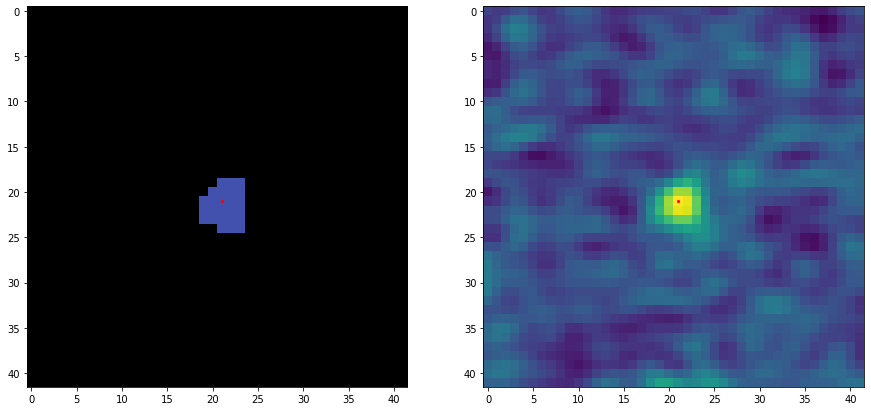

----------------------------------------------------------------------------------------------------


In [6]:
getImgs(rand_rows)

# Check Overlapping sources

In [22]:
# Load overlapping sources
overlaps = []
with open('../2.Overlap/overlap_pairs.csv', 'r') as infile:
    for line in infile:
        overlaps.append(np.array([pair.split(', ') for pair in line[2:-3].split('), (')], dtype=int))        

overlaps[:5]

[array([[   32,  1662],
        [   70,  9572],
        [   41, 11002],
        [  165,  1068]]),
 array([[ 126, 5124],
        [ 213, 5776]]),
 array([[  133,  1537],
        [  160, 10512]]),
 array([[  26, 5680],
        [ 136, 8729]]),
 array([[  61, 6489],
        [ 118,  397]])]

In [80]:
idx = random.randint(0, len(overlaps))
match = []
for source in overlaps[idx]:
    match.append(np.where(( np.array(catalogue[["mosaic_id", "object"]]) == source).all(axis=1))[0][0] )


overlap_rows = catalogue.iloc[match]
overlap_rows.head()

,label,total_pixels,x_pixels,y_pixels,integrated_intensity,brightest_pixel,brightest_pixel_x,brightest_pixel_y,brightest_pixel_RA,brightest_pixel_DEC,...,fit_y_axis,fit_theta,deconv_x,deconv_y,integrated_intensity_fit,ratio_residual,mosaic,object,mosaic_id,overlap
722658.0,P215+50_10388,19,5,5,0.194639,0.000306962,7799,8265,213.173,51.278,...,1.69392,-0.402693,1.89876,0,0.198013,0.131916,P215+50,10388,102,2
2139709.0,P211+50_11917,17,5,4,0.176332,0.000301114,1990,8559,213.173,51.2783,...,1.72428,-0.398989,3.00907,0.697571,0.17789,0.0944527,P211+50,11917,170,1


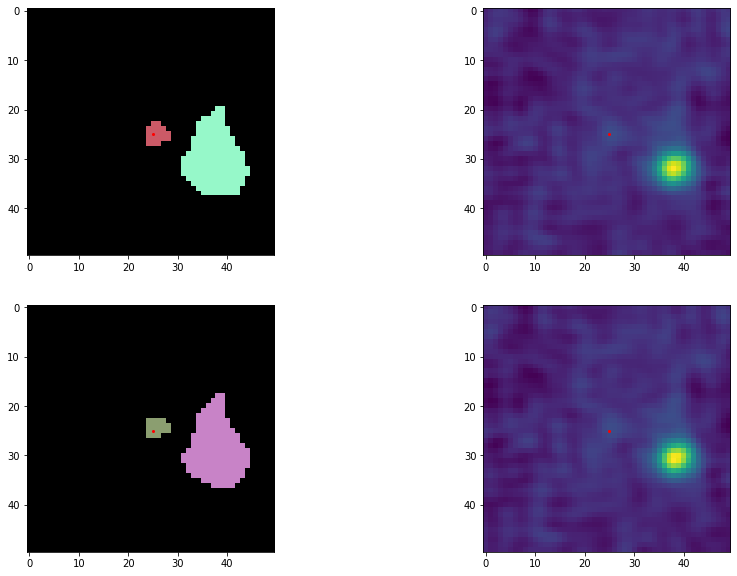

----------------------------------------------------------------------------------------------------


In [82]:
getImgs(overlap_rows, 20)

# Check Artifact

In [21]:
# Soon TM
artifact = catalogue[catalogue["label"] == "P209+42_7128"]
artifact.head()

,label,total_pixels,x_pixels,y_pixels,integrated_intensity,brightest_pixel,brightest_pixel_x,brightest_pixel_y,brightest_pixel_RA,brightest_pixel_DEC,...,fit_y_axis,fit_theta,deconv_x,deconv_y,integrated_intensity_fit,ratio_residual,mosaic,object,mosaic_id,overlap
34460.0,P209+42_7128,40,15,5,0.444151,0.000416371,6245,5686,208.116,43.0019,...,1.42743,0.196225,25.8435,0,0.456516,0.230281,P209+42,7128,35,0


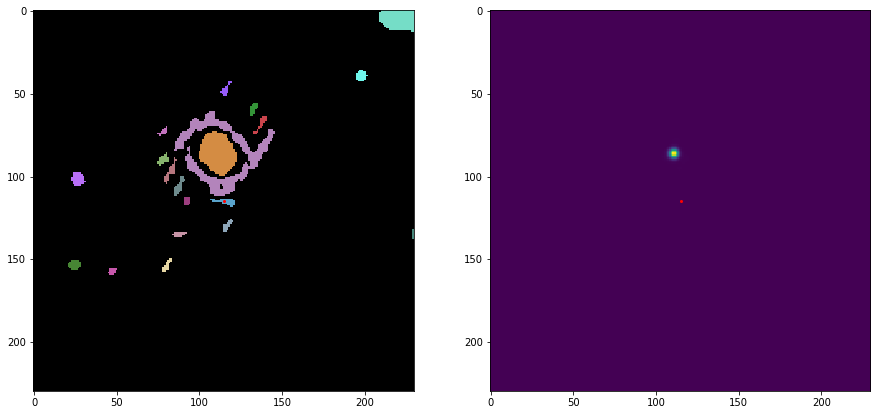

----------------------------------------------------------------------------------------------------


In [22]:
getImgs(artifact, 100)

In [120]:
myrows = catalogue.sort_values(by=["integrated_intensity"]).tail(100)
myrows.tail()

,label,total_pixels,x_pixels,y_pixels,integrated_intensity,brightest_pixel,brightest_pixel_x,brightest_pixel_y,brightest_pixel_RA,brightest_pixel_DEC,...,fit_y_axis,fit_theta,deconv_x,deconv_y,integrated_intensity_fit,ratio_residual,mosaic,object,mosaic_id,overlap
2061948,P160+57_12390,7035,108,213,23988.087593,6.381352,7203,7380,158.393901,58.236848,...,18.765953,-0.185001,3.586436,44.009035,24371.837576,0.416360,P160+57,12390,164,0
1980179,P141+45_10079,18904,284,191,29852.276741,1.265862,7265,7542,140.268371,45.633618,...,7.433488,-0.929135,121.087843,17.041376,29855.106576,0.367899,P141+45,10079,193,0
1590751,P141+47_1563,18941,283,191,29852.935174,1.283912,6673,1405,140.268061,45.633701,...,7.435083,-0.932421,121.045113,17.045233,29847.027448,0.367865,P141+47,1563,121,0
1697125,P210+52_5961,11566,198,184,64571.671889,45.059420,1566,4256,212.835567,52.202281,...,2.141246,0.837600,4.183177,3.069897,61685.590227,0.057474,P210+52,5961,109,1
1664389,P214+52_5939,11665,196,185,64581.309933,45.724837,7944,4332,212.835568,52.202536,...,2.435255,-0.737390,3.003954,4.109197,61608.775485,0.058243,P214+52,5939,162,2


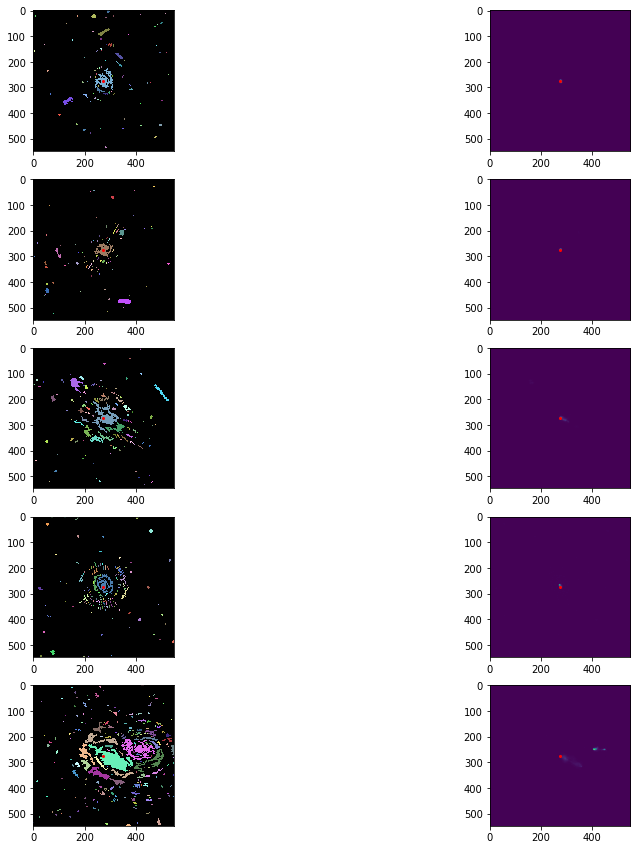

----------------------------------------------------------------------------------------------------


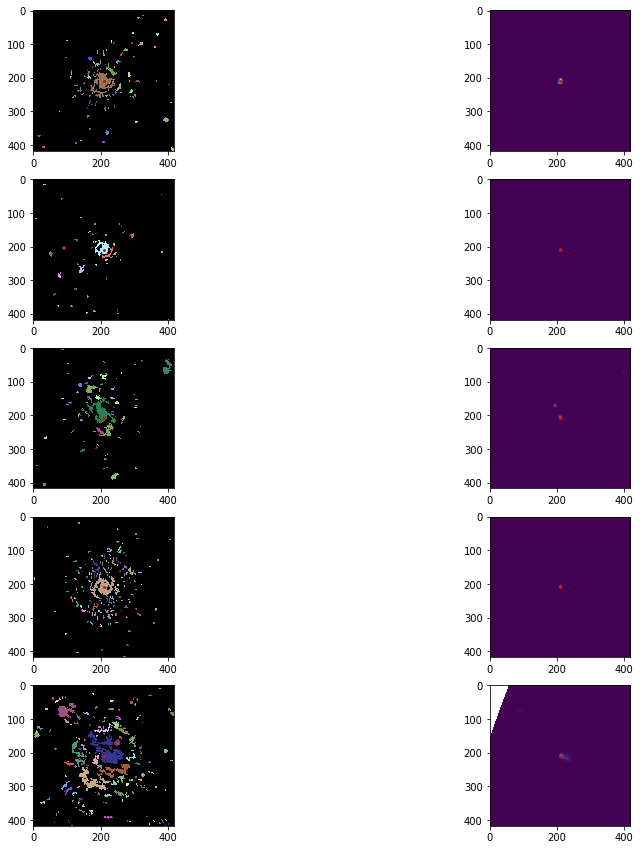

----------------------------------------------------------------------------------------------------


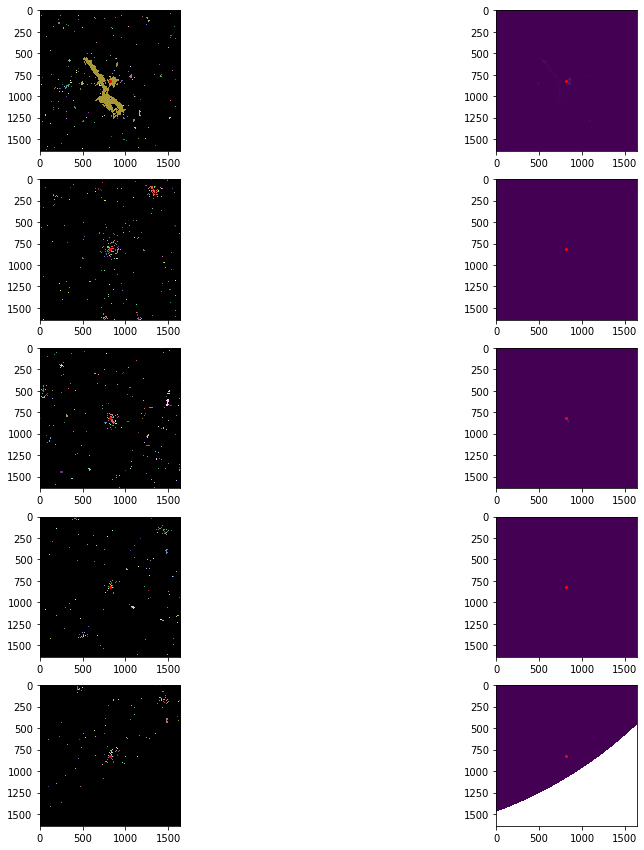

----------------------------------------------------------------------------------------------------


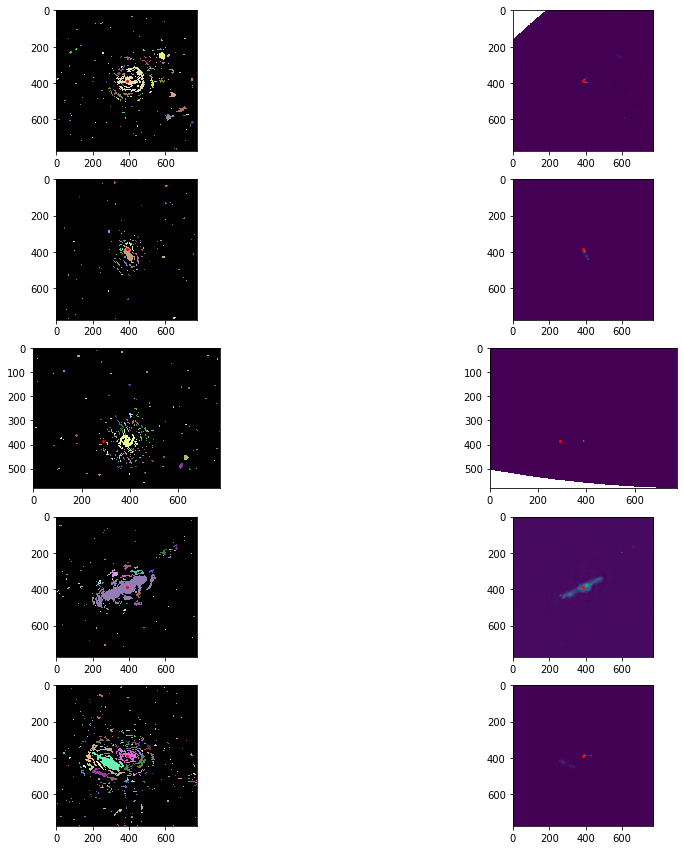

----------------------------------------------------------------------------------------------------


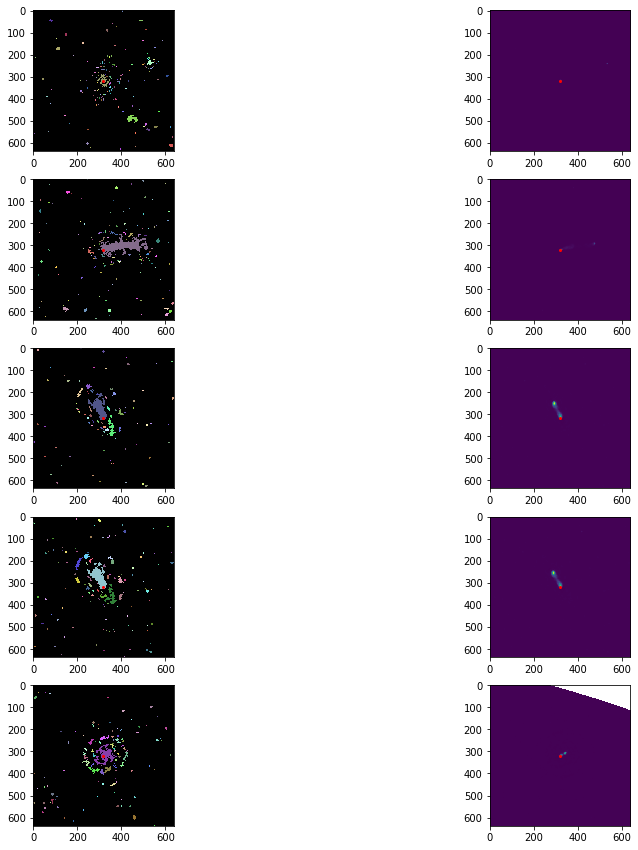

----------------------------------------------------------------------------------------------------


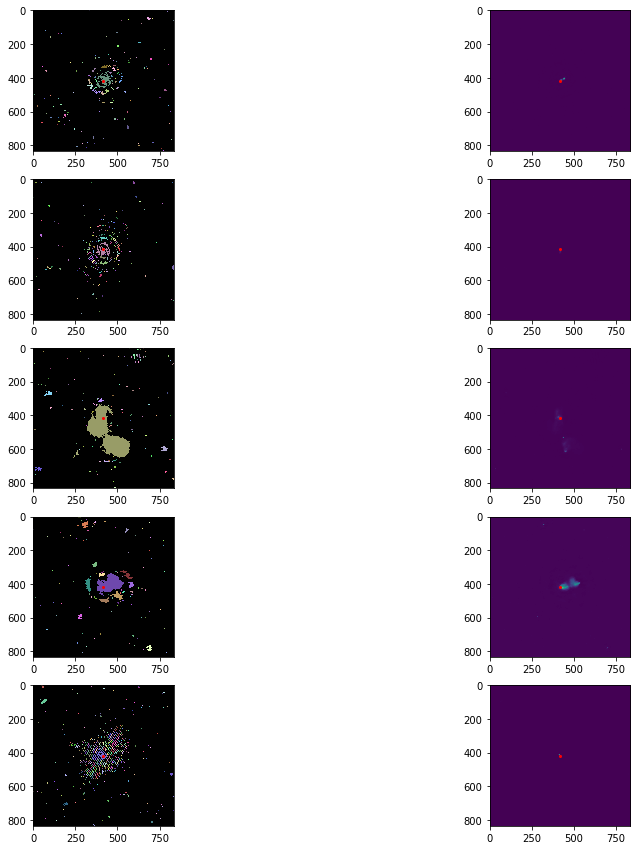

----------------------------------------------------------------------------------------------------


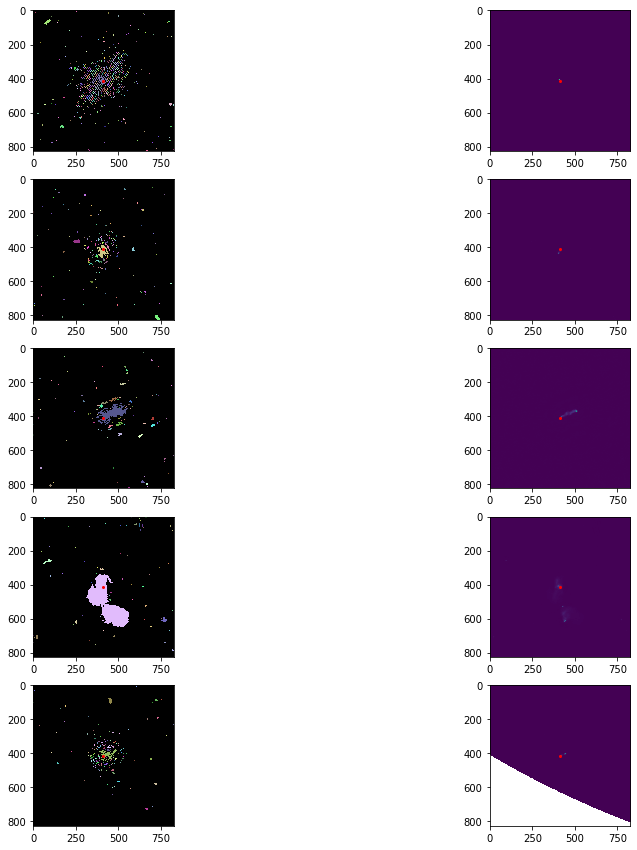

----------------------------------------------------------------------------------------------------


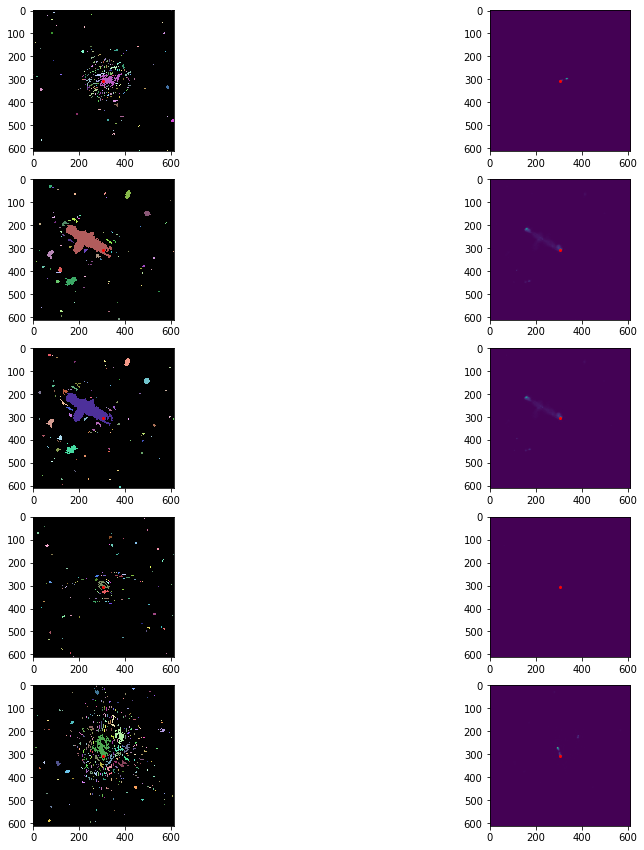

----------------------------------------------------------------------------------------------------


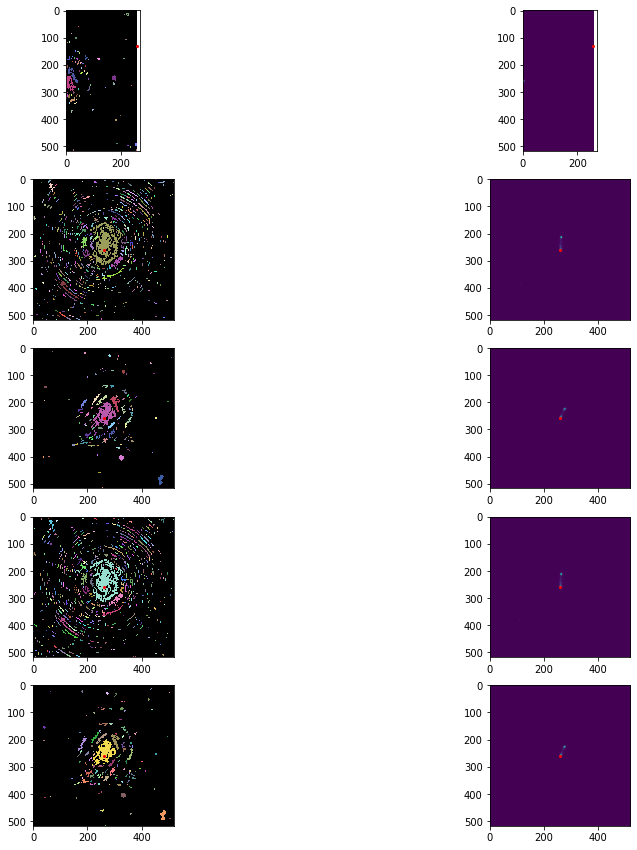

----------------------------------------------------------------------------------------------------


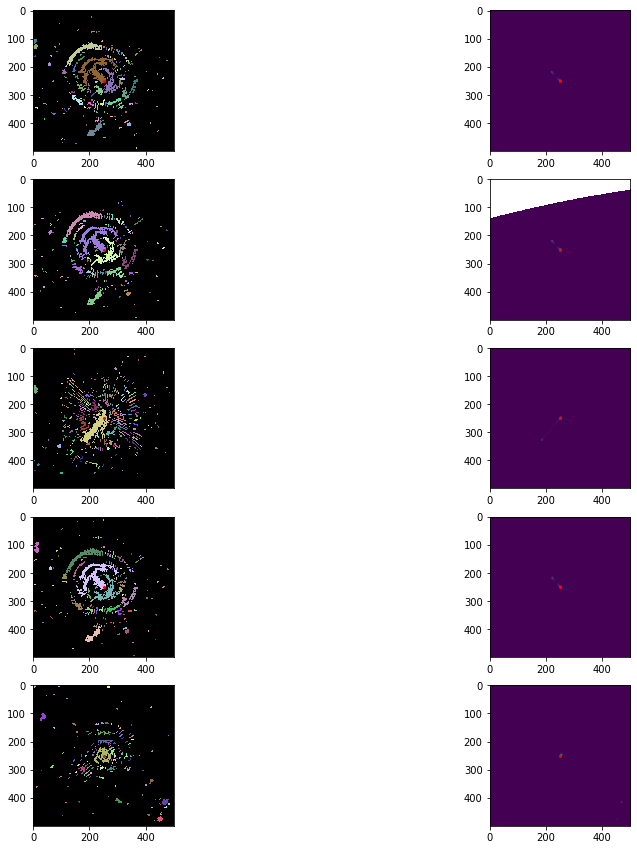

----------------------------------------------------------------------------------------------------


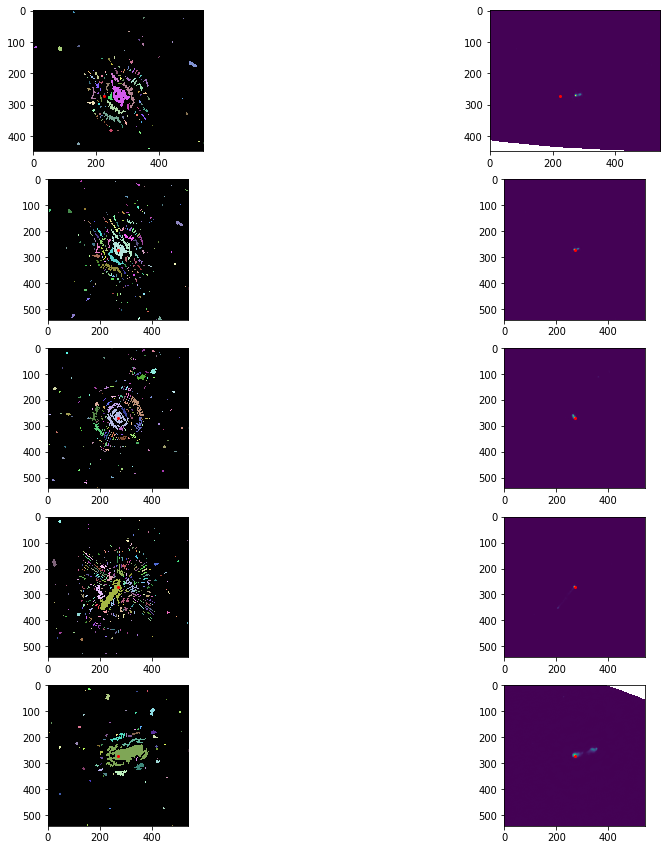

----------------------------------------------------------------------------------------------------


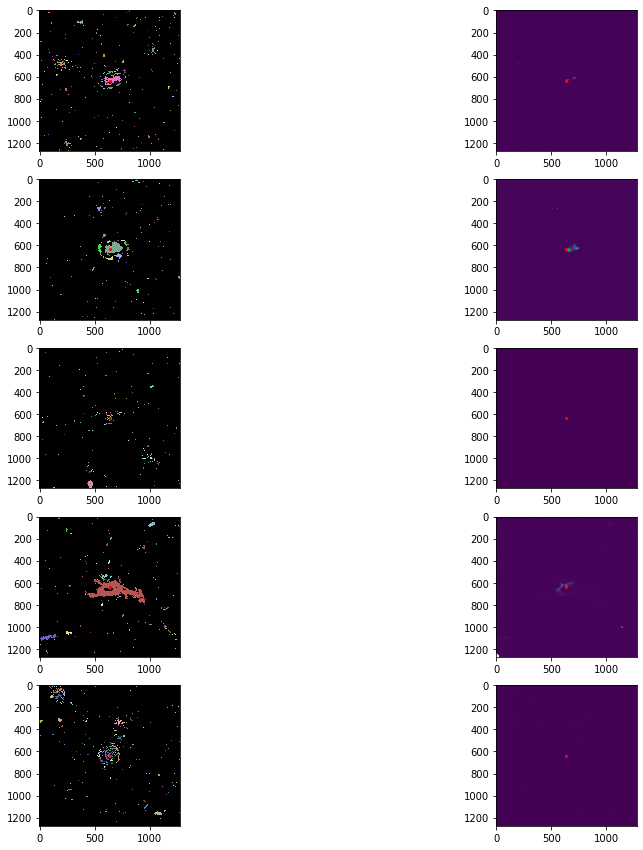

----------------------------------------------------------------------------------------------------


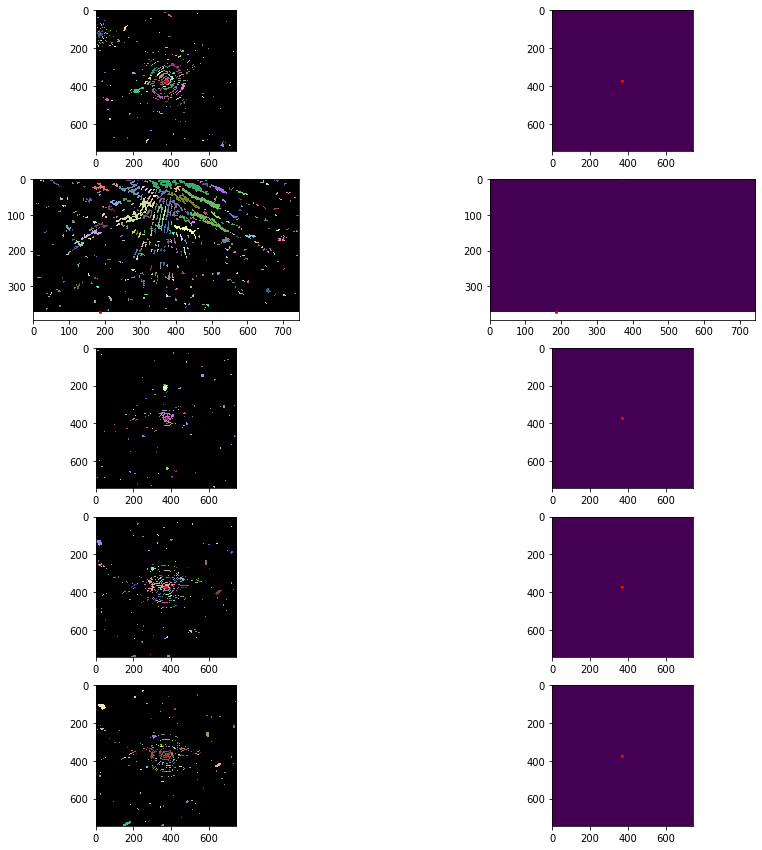

----------------------------------------------------------------------------------------------------


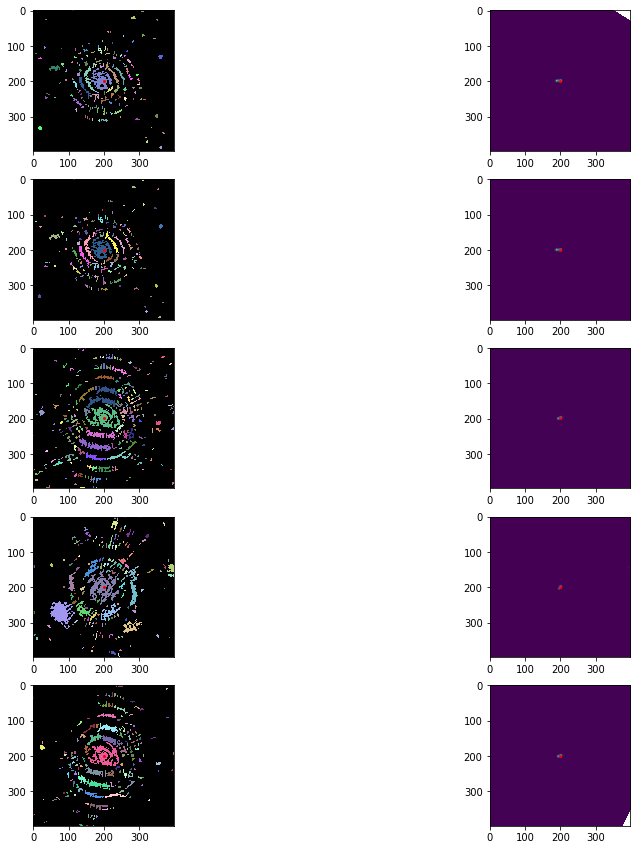

----------------------------------------------------------------------------------------------------


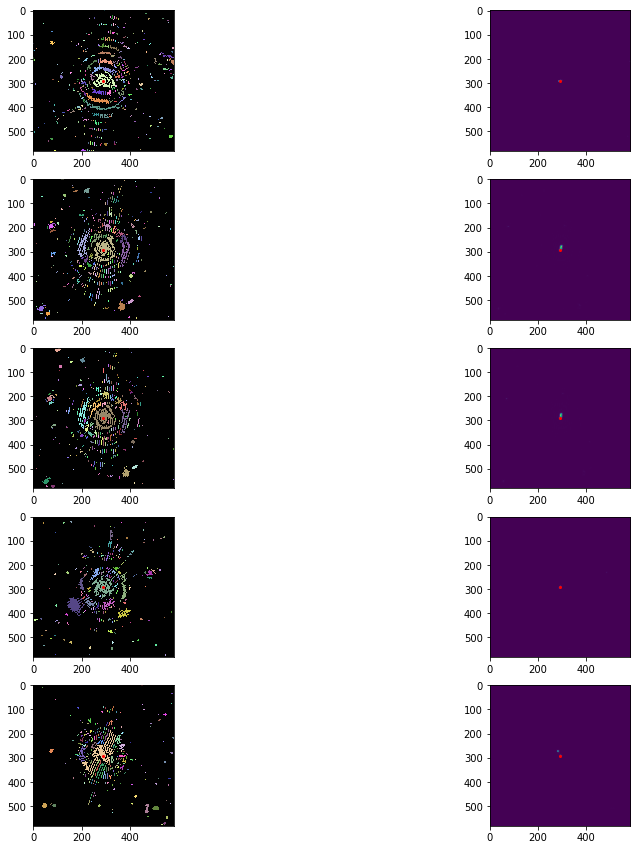

----------------------------------------------------------------------------------------------------


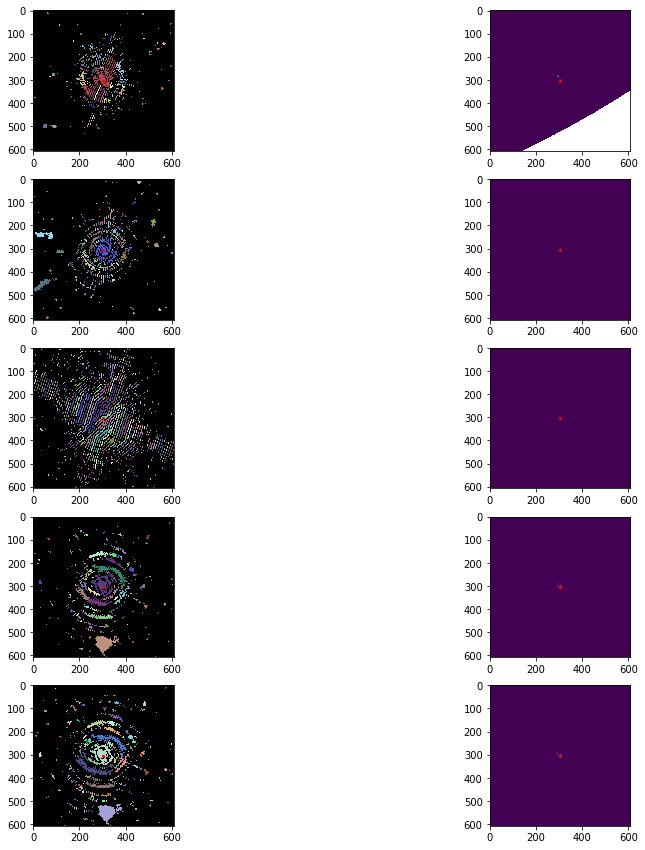

----------------------------------------------------------------------------------------------------


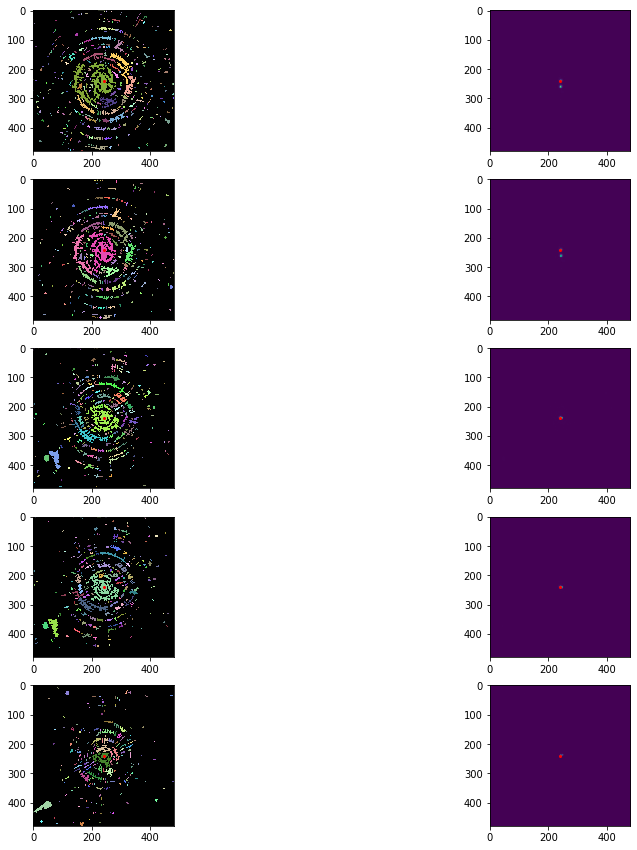

----------------------------------------------------------------------------------------------------


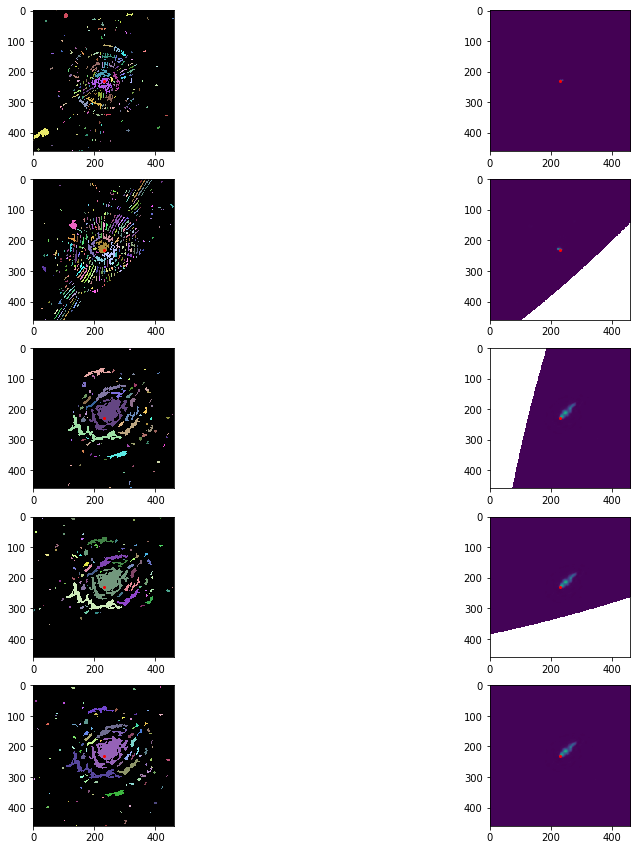

----------------------------------------------------------------------------------------------------


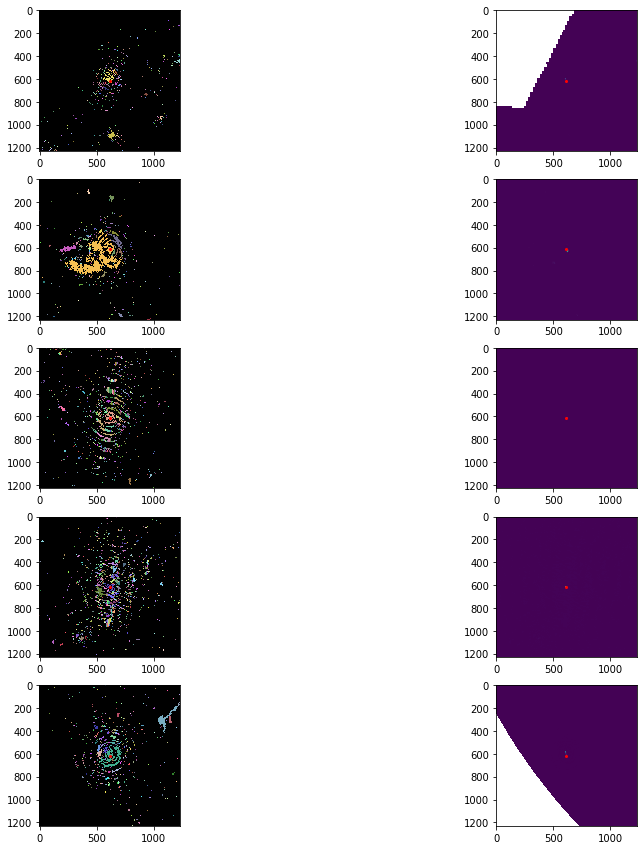

----------------------------------------------------------------------------------------------------


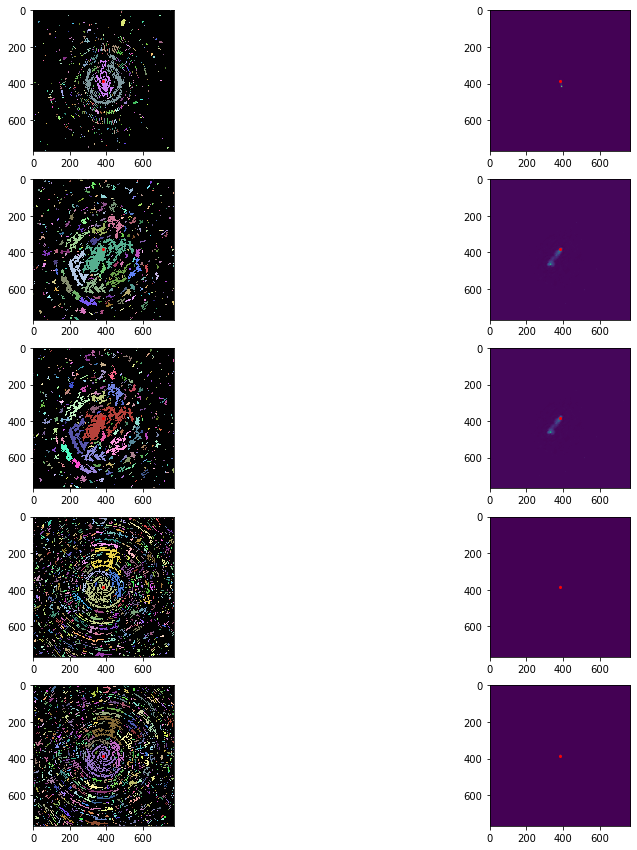

----------------------------------------------------------------------------------------------------


In [121]:
for chunk in range(0, len(myrows), 5):
    getImgs(myrows.iloc[chunk:chunk+5], 100)